In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import scipy.stats as stats

warnings.filterwarnings(action= 'ignore')

#### City of San Diego - Data SD
* Dataset name: Monitoring of Indicator Bacteria in Drinking Water
* URL: https://data.sandiego.gov/datasets/monitoring-of-indicator-bacteria-in-drinking-water/

In [40]:
# All Drinking Water Tests(Bacteria)
df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_datasd_v1.csv')
df.shape

(79850, 9)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79850 entries, 0 to 79849
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FR_NUM        79850 non-null  int64  
 1   date_sampled  79850 non-null  object 
 2   source        79850 non-null  object 
 3   sample_id     79850 non-null  object 
 4   t_coliform    79780 non-null  object 
 5   cl2_total     79850 non-null  float64
 6   e_coli        79791 non-null  object 
 7   temperature   79850 non-null  float64
 8   ph            79850 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 5.5+ MB


In [42]:
# sample of data
df.sample(5)

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
47803,348428,2020-06-08,152A SYS,W1373501,A,2.70,A,21.6,8.11
27123,313968,2018-06-19,78A SYS,W1246248,A,2.21,A,25.3,7.91
37355,332425,2019-07-09,173 SYS,W1313231,A,2.13,A,23.3,8.01
54511,358687,2021-01-11,262 SYS,W1410182,A,2.88,A,16.0,8.07
58777,364561,2021-05-20,285 SYS,W1431386,A,1.36,A,24.0,8.03


In [43]:
# Data Dictionary
dict_df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_dictionary_datasd.csv')
dict_df.fillna("")

,Field,Description,Possible values
0,sample_date,Date sample was taken,
1,site_ID,Unique identifier for the sample site,
2,temp_celsius,Temperature in Celsius,
3,chlorine,Chlorine in mg/l or ppm,
4,pH,pH of water sample,0-14
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [44]:
# Missing values
df.isnull().sum().sort_values(ascending=False)

t_coliform      70
e_coli          59
FR_NUM           0
date_sampled     0
source           0
sample_id        0
cl2_total        0
temperature      0
ph               0
dtype: int64

In [45]:
# Value counts for t_coliform, to determine how to treat missing values
print(df.t_coliform.fillna("<").value_counts())

# Values A and P are valid according to dictionary, "missing" and "<" values will be removed
# Update 't_coliform' with "<" so that it is easier to delete in next step
df['t_coliform'] = df.t_coliform.fillna("<")

# Since missing values and "<" are not in data dictionary; delete rows
df = df.query("t_coliform != '<'")
print("\n","df shape after dropping t_coliform invalid rows:")
print(df.shape)

# Missing values re-check
print("\n")
print('''Missing values re-check. e_coli missing values were part of 
deleted rows, no further action required for missing data''')
print(df.isnull().sum().sort_values(ascending=False))

A    79548
<      176
P      126
Name: t_coliform, dtype: int64

 df shape after dropping t_coliform invalid rows:
(79674, 9)


Missing values re-check. e_coli missing values were part of 
deleted rows, no further action required for missing data
FR_NUM          0
date_sampled    0
source          0
sample_id       0
t_coliform      0
cl2_total       0
e_coli          0
temperature     0
ph              0
dtype: int64


In [46]:
# Data conversion
df['date_sampled'] =  pd.to_datetime(df.date_sampled)

In [47]:
print('''A value_counts for sample_id shows that there 
are multiple rows per sample_id:''')
df.sample_id.value_counts().head()

A value_counts for sample_id shows that there 
are multiple rows per sample_id:


W1465493    16
W1330400    16
W1496667    16
W1548581    16
W1435907    16
Name: sample_id, dtype: int64

In [48]:
print('''Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.''')

df.query("sample_id == 'W1377043'")

Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
48442,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48443,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48444,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48445,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48446,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48447,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48448,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48449,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48450,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.24
48451,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.28


In [49]:
# Create dataframe from value_counts to identify columns that can be updated, as they appear to be duplicates
df2 = df[['FR_NUM', 'date_sampled', 'source', 'sample_id']].value_counts().to_frame(name='Counts')

df2 = df2.reset_index() # places "Counts" into the header row with all other columns

# Only keep columns with Counts greater than 1
df2 = df2.query("Counts > 1")

# Merge values from original dataframe, to get averages for these rows requiring averages for duplicate rows
df2 = df2.merge(df, left_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), right_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), how="inner")

In [50]:
# Function to get averages (mean) for cl2_total, temperature, and ph, by FR_NUM
def means(df, frnum):

    fr_num = pd.DataFrame(df.query('FR_NUM == @frnum').FR_NUM.unique()).iloc[0].values[0]
    cl2_total_mean = round(df.query('FR_NUM == @frnum').cl2_total.mean(),3)
    temperature_mean = round(df.query('FR_NUM == @frnum').temperature.mean(),3)
    ph_mean = round(df.query('FR_NUM == @frnum').ph.mean(),2)

    return fr_num,cl2_total_mean, temperature_mean, ph_mean

In [51]:
# Itirate through FR_NUM values to get averages from the means function above
# This process completes in around 1m 29s in Colab (+/- 22 seconds longer than local machine)

df2_means = []

for frn in (df2.FR_NUM.unique()):

    df2_means.append({'FR_NUM': round(pd.DataFrame(means(df2, frn)).iloc[0].values[0]),
                      'cl2_total_mean': pd.DataFrame(means(df2, frn)).iloc[1].values[0],
                      'temperature_mean': pd.DataFrame(means(df2, frn)).iloc[2].values[0],
                      'ph_mean': pd.DataFrame(means(df2, frn)).iloc[3].values[0]})

In [52]:
# Merge average values into original dataframe
df = df.merge(pd.DataFrame(df2_means), left_on=('FR_NUM'), right_on=('FR_NUM'), how="left")

In [53]:
# Make updates to features with variations
# The use of "left" in the merge statement above, left non-duplicate values empty; hence the accounting for them
# in the fillna statements below:
df['cl2_total'] = np.where(df.cl2_total_mean.fillna("") != "", df.cl2_total_mean, df.cl2_total)
df['temperature'] = np.where(df.temperature_mean.fillna("") != "", df.temperature_mean, df.temperature)
df['ph'] = np.where(df.ph_mean.fillna("") != "", df.ph_mean, df.ph)

In [54]:
# With all variations gone, we can now drop duplicates. The two df "shapes" below, are a before and after dropping duplicates.
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(79674, 12)
(58865, 12)


In [55]:
print('''Verify that sample_id values are now unique (1 equals unique):''')
str(pd.DataFrame(df.sample_id.value_counts().to_frame(name='Counts').reset_index()).Counts.unique())

Verify that sample_id values are now unique (1 equals unique):


'[1]'

In [56]:
# Drop unnecessary columns for remainder of the process - used in previous steps
df = df.drop(['cl2_total_mean', 'temperature_mean', 'ph_mean'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58865 entries, 0 to 79673
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FR_NUM        58865 non-null  int64         
 1   date_sampled  58865 non-null  datetime64[ns]
 2   source        58865 non-null  object        
 3   sample_id     58865 non-null  object        
 4   t_coliform    58865 non-null  object        
 5   cl2_total     58865 non-null  float64       
 6   e_coli        58865 non-null  object        
 7   temperature   58865 non-null  float64       
 8   ph            58865 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 4.5+ MB


In [68]:
# View a 5 rows from head of file and 5 rows from tail of file
df

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
0,244324,2014-06-05,244 SYS,W983115,A,1.91,A,23.4,8.02
1,244325,2014-06-05,245 SYS,W983116,A,1.77,A,24.3,7.99
2,244326,2014-06-05,66 SYS,W983117,A,1.95,A,25.5,8.02
3,244328,2014-06-05,250 SYS,W983119,A,2.40,A,22.6,8.02
4,244329,2014-06-05,248A SYS,W983120,A,1.82,A,24.2,7.96
...,...,...,...,...,...,...,...,...,...
79669,395886,2023-03-15,257 SYS,W1559957,A,2.10,A,17.8,8.10
79670,395887,2023-03-15,333 SYS,W1559958,A,2.10,A,18.2,7.98
79671,395888,2023-03-15,53 SYS,W1559959,A,0.99,A,18.5,7.96
79672,395889,2023-03-15,55A SYS,W1559961,A,2.50,A,17.2,8.25


In [70]:
# Based on the results from the above, it appears the data is ordered by date_sampled

# To ensure that all rows are following this pattern, the next step will 
# sort rows by date_sampled, source, and sample_id to get a chronological

df = df.sort_values(['date_sampled', 'FR_NUM'], ascending=[True, True])

In [73]:
# reset index, drop original index
df.reset_index(drop=True, inplace=True)

#### Outliers


In [75]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable):
    # function takes a dataframe and
    # the variable of interest

    # define plot figure size
    plt.figure(figsize=(16,4))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [76]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return lower_boundary, upper_boundary

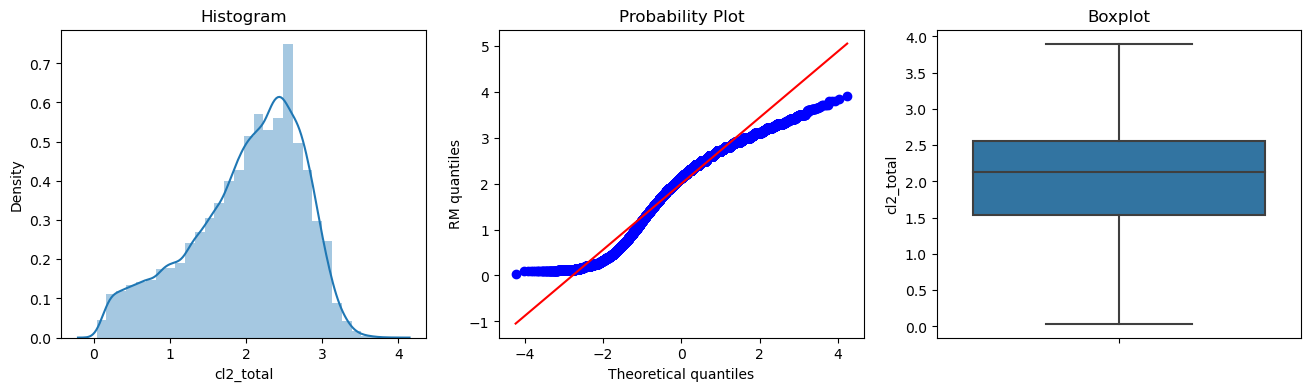

count    58865.000000
mean         1.998466
std          0.735005
min          0.040000
25%          1.540000
50%          2.130000
75%          2.560000
max          3.900000
Name: cl2_total, dtype: float64

In [77]:
diagnostic_plots(df, 'cl2_total')
df.cl2_total.describe()

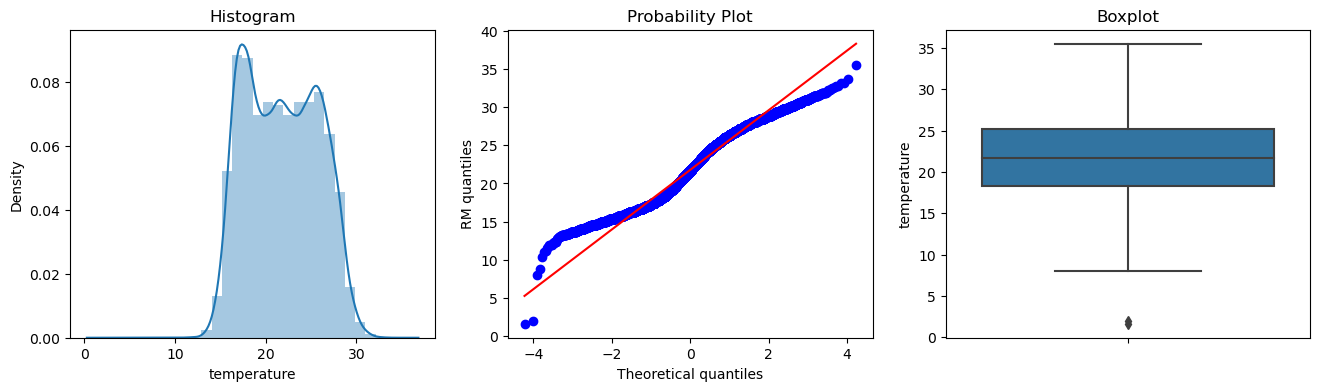

count    58865.000000
mean        21.790130
std          3.968129
min          1.630000
25%         18.300000
50%         21.700000
75%         25.200000
max         35.500000
Name: temperature, dtype: float64

In [78]:
diagnostic_plots(df, 'temperature')
df.temperature.describe()

In [79]:
# find lower and upper boundaries of 'temperature'
temperature_lower_limit, temperature_upper_limit = find_normal_boundaries(df, 'temperature', 3)

# Apply boundaries to outliers
df['temperature'] = np.where(df['temperature'] > temperature_upper_limit, temperature_upper_limit,
                     np.where(df['temperature'] < temperature_lower_limit, temperature_lower_limit,
                      df['temperature']))

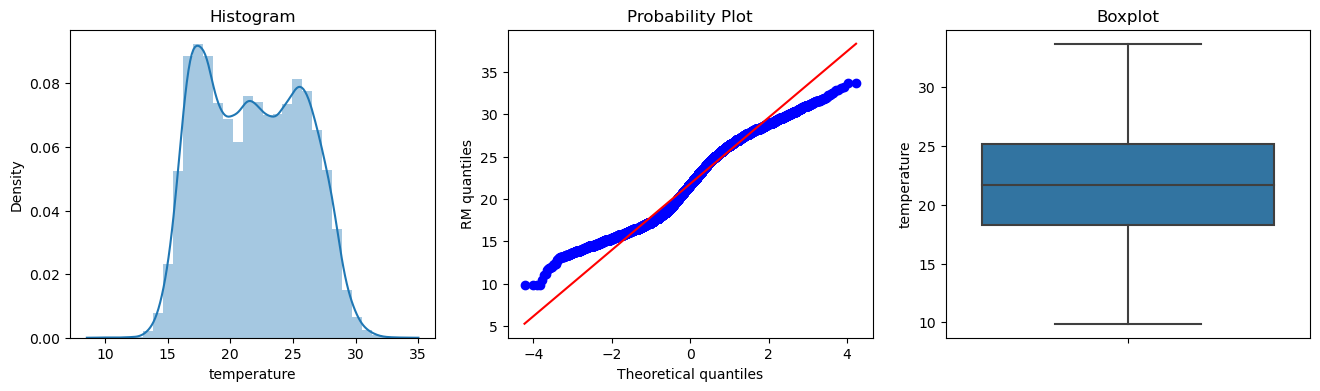

count    58865.000000
mean        21.790425
std          3.966761
min          9.885742
25%         18.300000
50%         21.700000
75%         25.200000
max         33.694517
Name: temperature, dtype: float64

In [80]:
# Verify changes to temperature feature
diagnostic_plots(df, 'temperature')
df.temperature.describe()

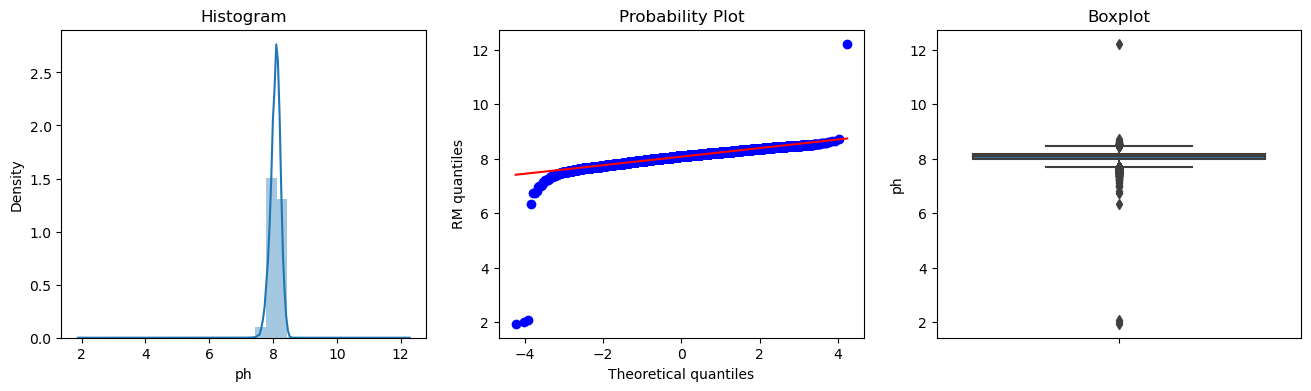

count    58865.000000
mean         8.074410
std          0.163693
min          1.940000
25%          7.980000
50%          8.090000
75%          8.180000
max         12.220000
Name: ph, dtype: float64

In [81]:
diagnostic_plots(df, 'ph')
df.ph.describe()

In [82]:
# find lower and upper boundaries of 'ph'
ph_lower_limit, ph_upper_limit = find_normal_boundaries(df, 'ph', 3)

# Apply boundaries to outliers
df['ph'] = np.where(df['ph'] > ph_upper_limit, ph_upper_limit,
                     np.where(df['ph'] < ph_lower_limit, ph_lower_limit,
                      df['ph']))

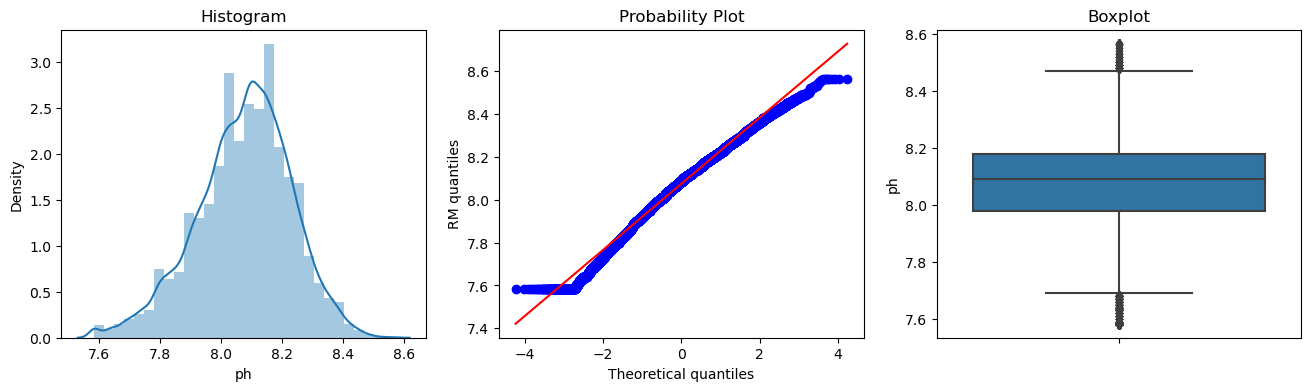

count    58865.000000
mean         8.075026
std          0.155230
min          7.583330
25%          7.980000
50%          8.090000
75%          8.180000
max          8.565490
Name: ph, dtype: float64

In [83]:
diagnostic_plots(df, 'ph')
df.ph.describe()

#### Business purpose (from website)

* A positive result for coliform from one single test is not enough to constitute an MCL (Maximum Contaminant Level) violation. An acute violation occurs when a site that initially tested positive is repeat tested and either the initial sample or one of the repeat samples is positive for E. coli. A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. A positive coliform result from a single routine test may be due to sampling error or bacteria in the testing mechanism but not in the drinking water pipes.

In [84]:
print('''There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all {} rows, which is 'absent' e_coli.'''.format(pd.DataFrame(df.e_coli.value_counts()).iloc[0].values[0]))

df.e_coli.value_counts()

There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all 58865 rows, which is 'absent' e_coli.


A    58865
Name: e_coli, dtype: int64

In [85]:
print('''A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature.''',"\n")

df.t_coliform.value_counts()

A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature. 



A    58759
P      106
Name: t_coliform, dtype: int64

#### Feature Engineering


In [86]:
# Adding a month-year value to best identify MCL violations
df['year'] = pd.DatetimeIndex(df.date_sampled).year
df['month'] = pd.DatetimeIndex(df.date_sampled).month
df['yearMonth'] =  df.year.astype(str) + '-' + df.month.astype(str)

In [87]:
# Identify yearMonth where t_coliform was Present, 'P'
ym_df = pd.DataFrame(df.query("t_coliform == 'P'").yearMonth.unique())
ym_df.columns = ['yearMonth']

# Get all data from df for yearMonth where there was t_coliform present
ym_df = df.merge(ym_df, left_on='yearMonth', right_on='yearMonth', how='inner')

In [88]:
# Crosstab results, into dataframe
ym_df = pd.DataFrame(pd.crosstab(ym_df.yearMonth, ym_df.t_coliform)).reset_index()

# Add a Total column
ym_df['Total'] = ym_df.A + ym_df.P

# Add a t_coli percent column, representing the percentage of cases in the month, when t_coli was Present
ym_df['yearMonth_t_coli_pct'] = round(ym_df.P / ym_df.Total * 100)

In [89]:
# Add yearMonth_t_coli_pct to main dataframe
df = df.merge(ym_df[['yearMonth', 'yearMonth_t_coli_pct']], left_on='yearMonth', right_on='yearMonth', how='left')

# Update Nan values to 0.0
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.fillna(0.0)

In [90]:
print('''There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only.''',"\n")
df.yearMonth_t_coli_pct.value_counts()

There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only. 



0.0    50477
1.0     8388
Name: yearMonth_t_coli_pct, dtype: int64

### EDA


There is no pattern for years when t_coli_pct has equaled 1% for a given month in the year. 
From years 2015 to 2018, there was continued representation of the 1%. 



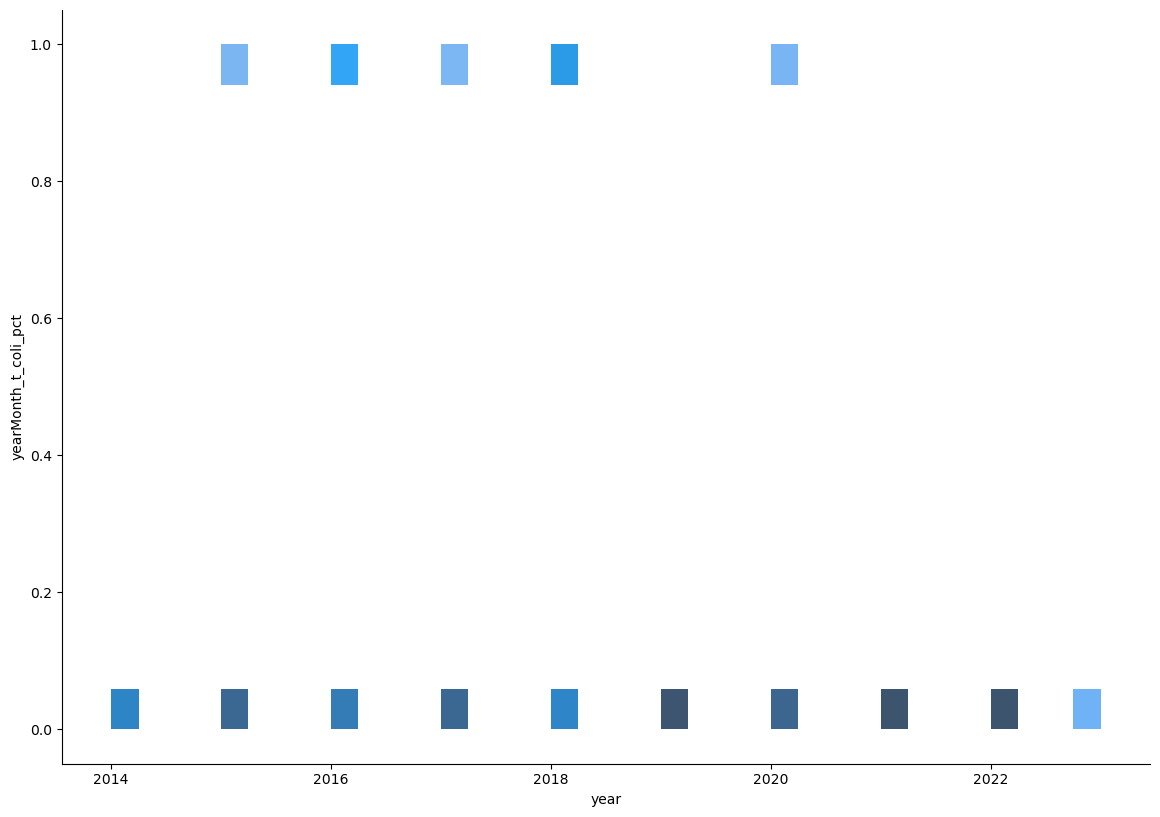

In [91]:
sns.displot(data=df, x='year', y='yearMonth_t_coli_pct', height=8.27, aspect=11.7/8.27)

print('''There is no pattern for years when t_coli_pct has equaled 1% for a given month in the year. 
From years 2015 to 2018, there was continued representation of the 1%.''',"\n")

From years 2015 to 2018, there was a continued dip in the mean of ph values. 



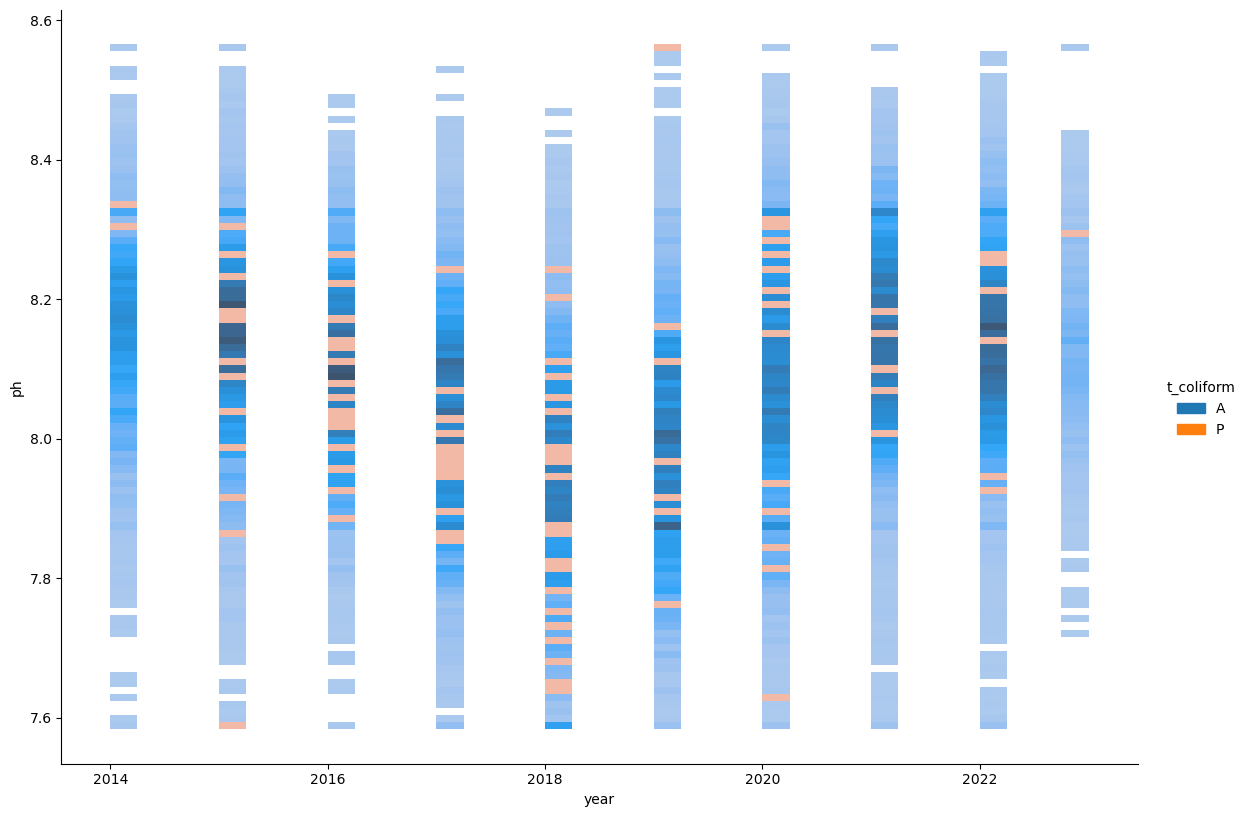

In [92]:
print('''From years 2015 to 2018, there was a continued dip in the mean of ph values.''',"\n")

sns.displot(data=df, x='year', y='ph', hue='t_coliform', height=8.27, aspect=11.7/8.27)

From years 2015 to 2018, it appears water temperature did not have the same range, 
it appears tighter range than in other years. 



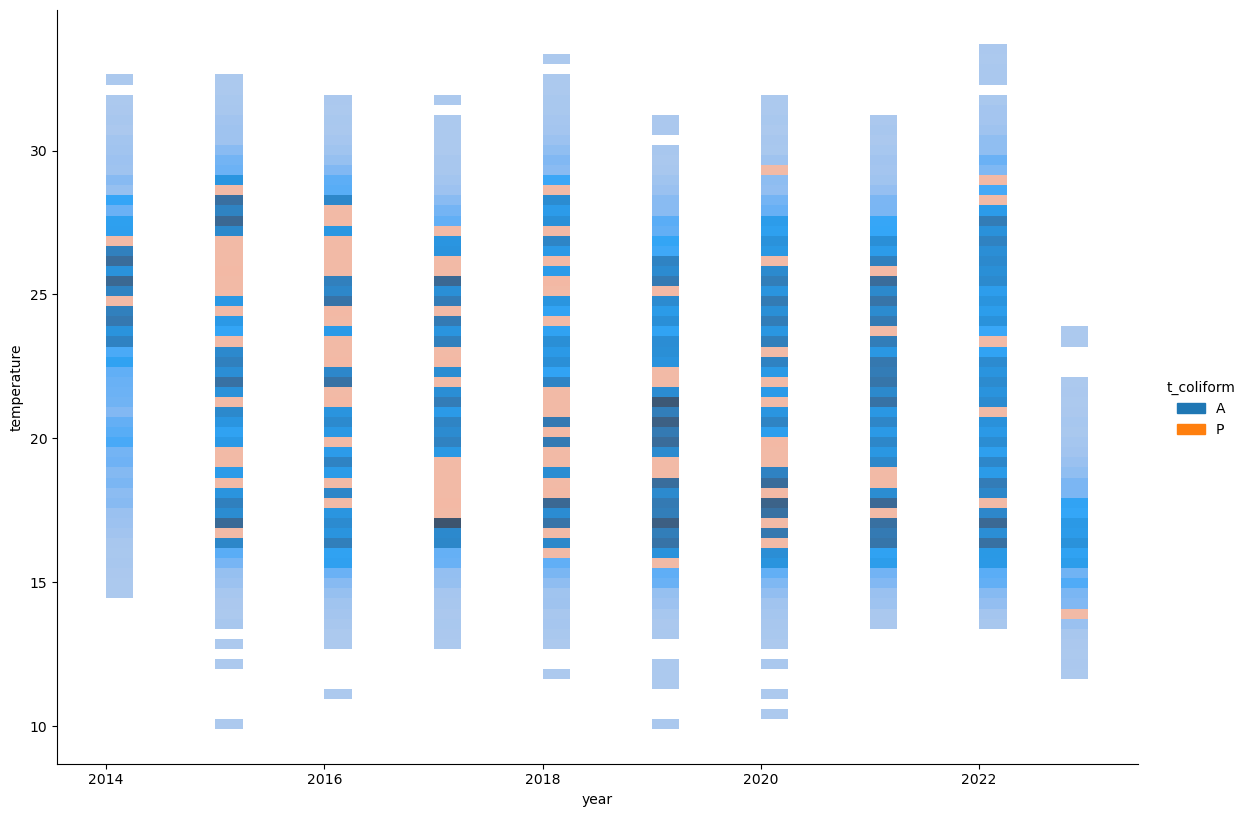

In [93]:
print('''From years 2015 to 2018, it appears water temperature did not have the same range, 
it appears tighter range than in other years.''',"\n")

sns.displot(data=df, x='year', y='temperature', hue='t_coliform', height=8.27, aspect=11.7/8.27)

From years 2015 to 2018, there appear to be outliers of cl2_total, 
beginning in 2014 and leveling off in 2018. 



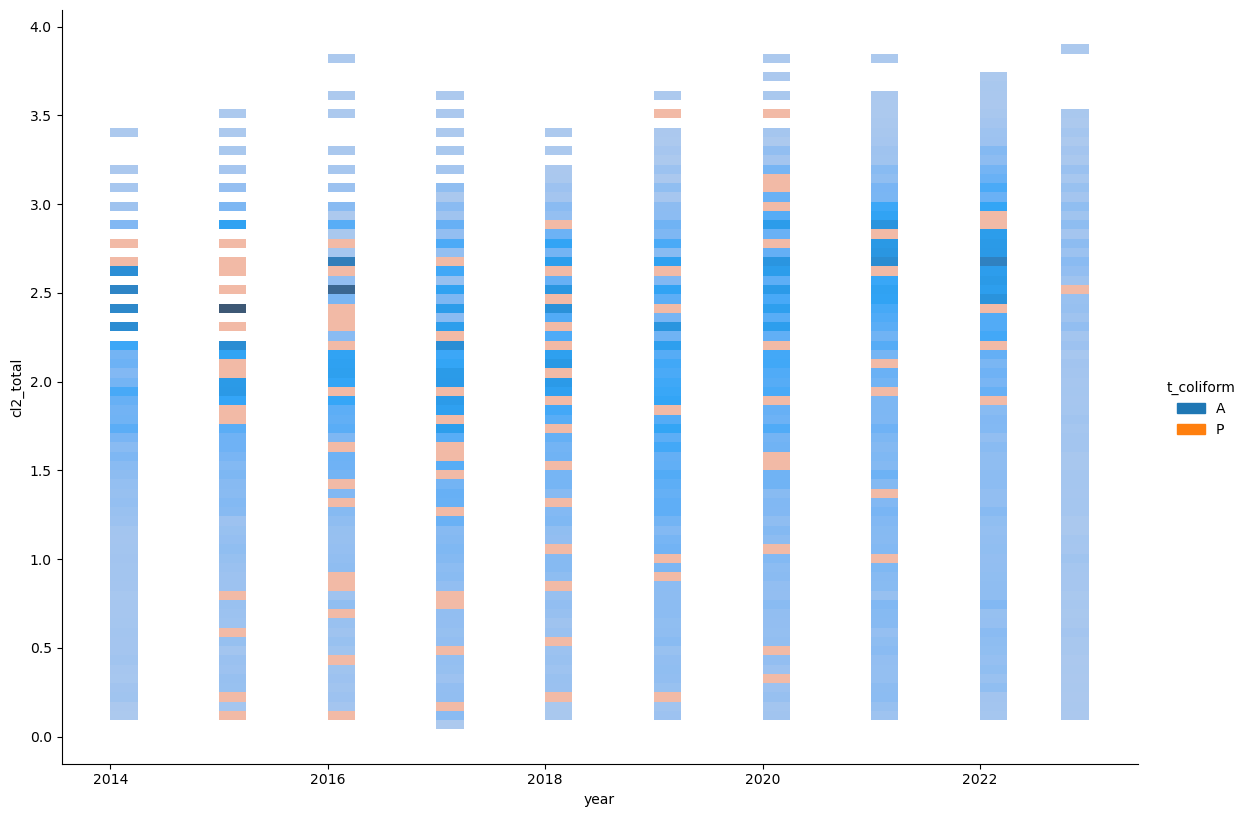

In [94]:
print('''From years 2015 to 2018, there appear to be outliers of cl2_total, 
beginning in 2014 and leveling off in 2018.''',"\n")

sns.displot(data=df, x='year', y='cl2_total', hue='t_coliform', height=8.27, aspect=11.7/8.27)

### Create a Target classifier, representing a source that had t_coliform present at any point in the dataset.
### source_t_coliform_historically

In [95]:
# Identify 'source' which has had t_coliform in the past
source_df = pd.DataFrame(df.query("t_coliform == 'P'").source.unique())
source_df.columns = ['source']
source_df['source_t_coliform_historically'] = 1

In [96]:
# Merge source_df into main dataframe
df = df.merge(source_df, left_on='source', right_on='source', how='left')

# Convert missing values to 0
df['source_t_coliform_historically'] = df.source_t_coliform_historically.fillna(0)

# Convert to int
df['source_t_coliform_historically'] = df.source_t_coliform_historically.astype(int)

In [97]:
# initiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# LabelEncoder 'source' feature
le.fit(df['source'])
df['source_le'] =  le.transform(df['source'])

# LabelEncoder 'yearMonth' feature
le.fit(df['yearMonth'])
df['yearMonth_le'] =  le.transform(df['yearMonth'])

In [98]:
# Binary values for t_coliform
df['t_coliform_bin'] = np.where(df.t_coliform == 'A', 0, 1)

## Proposed target variable

<AxesSubplot:>

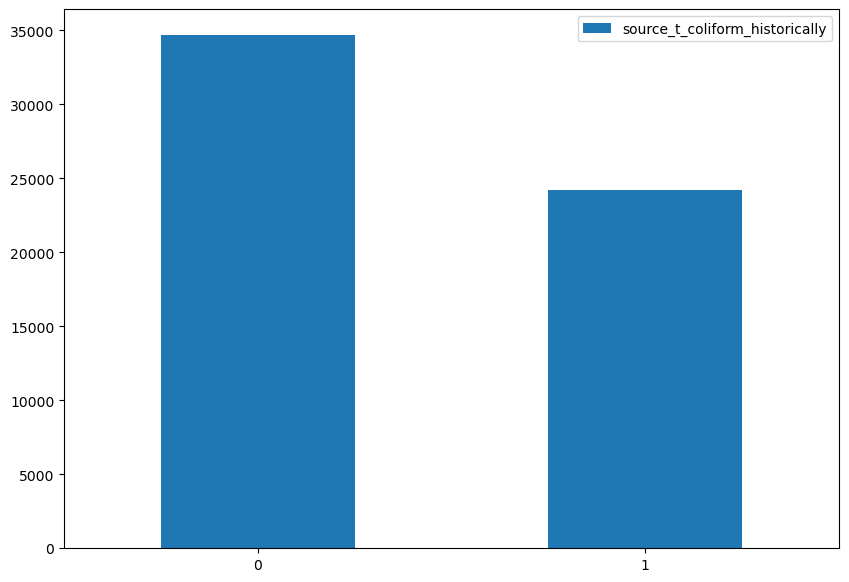

In [99]:
# More than half of the "sources" have had t_coliform present at some point
pd.DataFrame(df.source_t_coliform_historically.value_counts()).plot.bar(rot=0, stacked=True, figsize=(10,7))

This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time. 



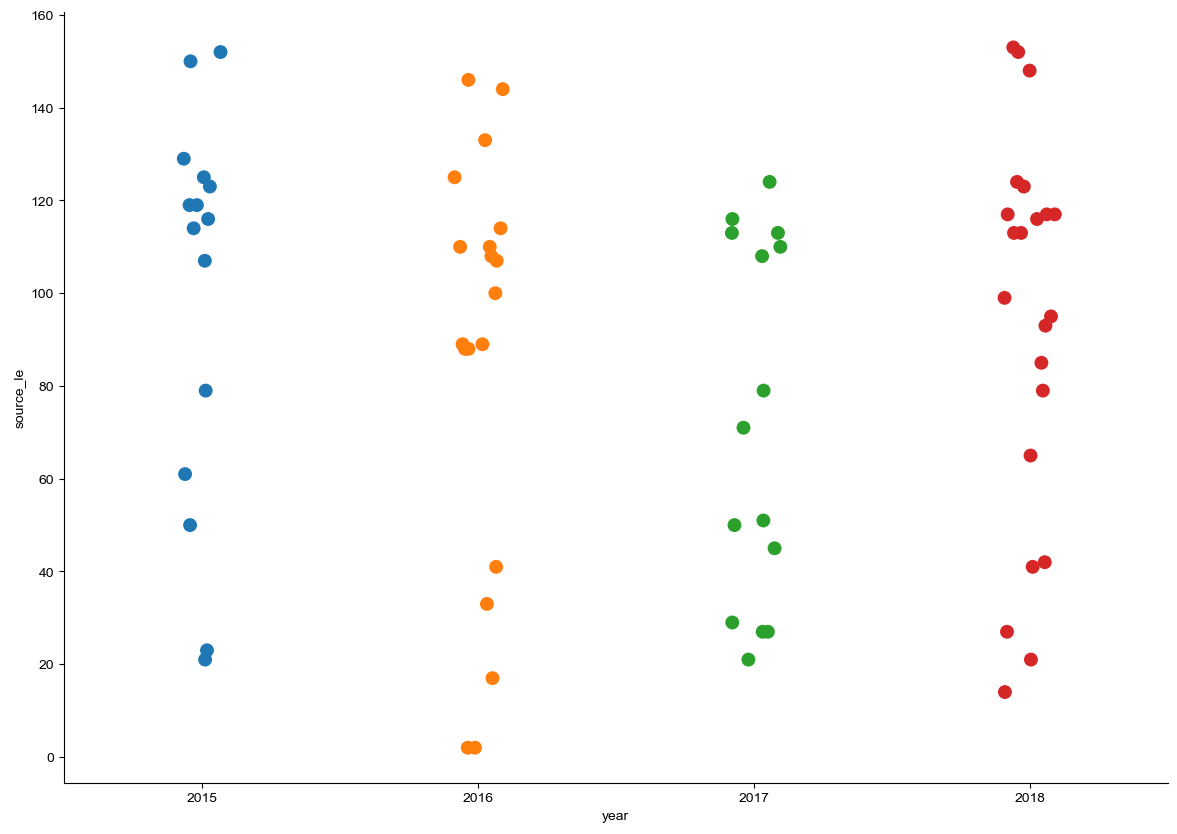

In [100]:
print('''This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time.''',"\n")

sns.catplot(data=df.query("t_coliform_bin == 1 and year <= 2018 and year >= 2015"), x='year', y='source_le', s=10, height=8.27, aspect=11.7/8.27)
sns.set_style("ticks",{'axes.grid' : True})

<AxesSubplot:>

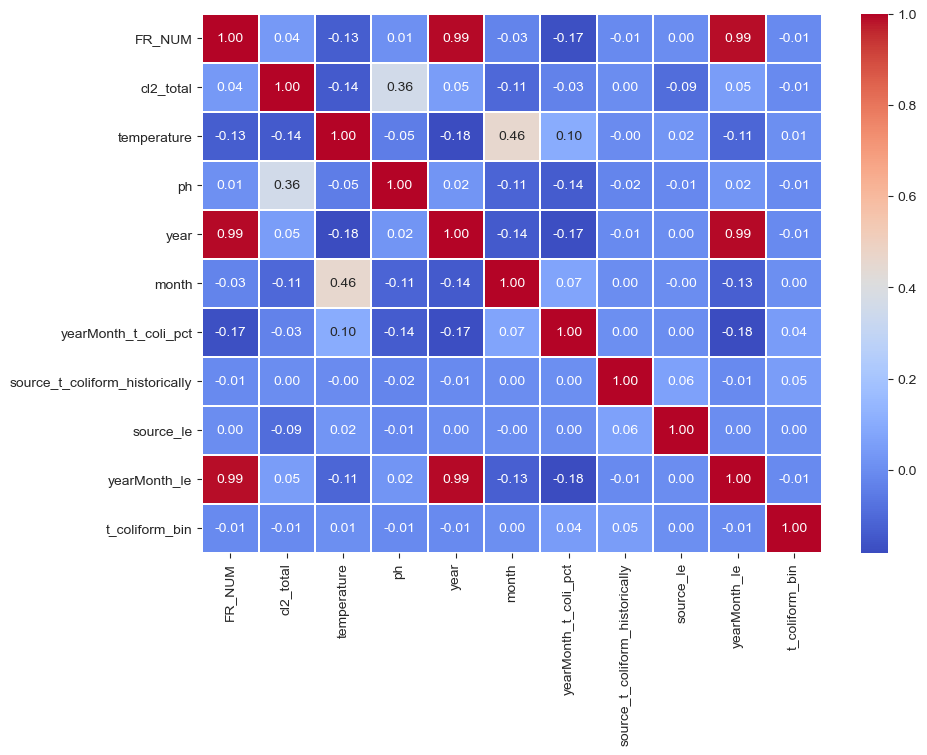

In [101]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (10, 7))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)

## Logistic Regression

In [72]:
X_lr = df.loc[ : , df.columns != 'source_t_coliform_historically'].select_dtypes(exclude=['object', 'datetime'])
y_lr = df[['source_t_coliform_historically']]

# Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X_lr,y_lr,random_state=700, test_size=0.30)
print(" X_train     y_train    X_test      y_test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,"\n")

# Drop columns whose p value is too high after viewing summary for source_t_coliform_historically
X_lr.info()
X_lr.drop(X_lr.columns[[0,7,5,6,8,2,4,1]], axis=1, inplace=True)
print("\n","shape after dropping columns:",X_lr.shape)

 X_train     y_train    X_test      y_test
(39831, 10) (39831, 1) (17071, 10) (17071, 1) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56902 entries, 0 to 56901
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FR_NUM                56902 non-null  int64  
 1   cl2_total             56902 non-null  float64
 2   temperature           56902 non-null  float64
 3   ph                    56902 non-null  float64
 4   year                  56902 non-null  int64  
 5   month                 56902 non-null  int64  
 6   yearMonth_t_coli_pct  56902 non-null  float64
 7   source_le             56902 non-null  int64  
 8   yearMonth_le          56902 non-null  int64  
 9   t_coliform_bin        56902 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 4.8 MB

 shape after dropping columns: (56902, 2)


In [73]:
# Add constant
X_lr = sm.add_constant(X_lr)

# Run the model
lr_model = sm.OLS(y_lr, X_lr).fit()

# View the model's summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     source_t_coliform_historically   R-squared:                       0.003
Model:                                        OLS   Adj. R-squared:                  0.003
Method:                             Least Squares   F-statistic:                     89.18
Date:                            Sat, 03 Dec 2022   Prob (F-statistic):           2.14e-39
Time:                                    00:25:38   Log-Likelihood:                -40121.
No. Observations:                           56902   AIC:                         8.025e+04
Df Residuals:                               56899   BIC:                         8.027e+04
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9001      0.106      8.495      0.000       0.692       1.108
ph                -0.0617      0.013     -4.702      0.000      -0.087      -0.036
t_coliform_bin     0.5955      0.048     12.446      0.000       0.502       0.689
==============================================================================
Omnibus:                   217375.705   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9514.120
Skew:                           0.400   Prob(JB):                         0.00
Kurtosis:                       1.163   Cond. No.                         423.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""